In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings("ignore")

import config

<IPython.core.display.Javascript object>

### Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

In [6]:
postgres_user = config.user
postgres_pw = config.password
postgres_host = config.host
postgres_port = config.port
postgres_db = "heartdisease"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from heartdisease", con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [8]:
# Making sure the data will split evenly
rows = df.shape[0] - df.shape[0] % 2
df = df.iloc[:rows, :]

<IPython.core.display.Javascript object>

In [12]:
# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# replace some random string values.
X=X.replace(to_replace='?', value=0)

# Make y binary
y=np.where(y>0,0,1)

# Scaling
scaled = StandardScaler().fit_transform(X)

# Data frame for feature and cluster labels
ypred = pd.DataFrame()

# Create 2-feture PCA for graphing purposes
pca = PCA(n_components=2)
x_pca = pca.fit_transform(scaled)

# Using train_test_split to divide the data into 4 groups
x_half1, x_half2, x_pcahalf1, x_pcahalf2 = train_test_split(scaled, x_pca, test_size = 0.5, random_state = 1234)

# Pass a list of tuples and a counter that increments each time we go through the loop.
# The tuples are the data to be used by k-means, adn the PCA-derived features for graphing.
# We use k-means to fit a model to the data, then store the predicted values and the 2-feature
# PCA solution in the data frame.

for counter, data in enumerate([(x_half1, x_pcahalf1), (x_half2, x_pcahalf2)]):
    # Put the features into ypred
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:,0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:,1]
    
    for j in range(2,5):
        pred = KMeans(n_clusters=j, random_state=1234).fit_predict(data[0])
        ypred['clust' + str(j) + '_sample' + str(counter)] = pred



<IPython.core.display.Javascript object>

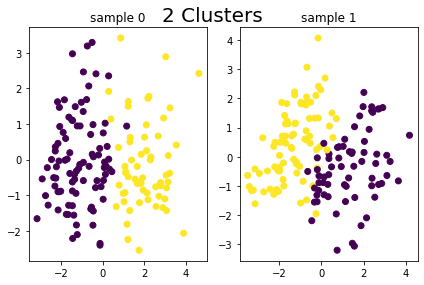

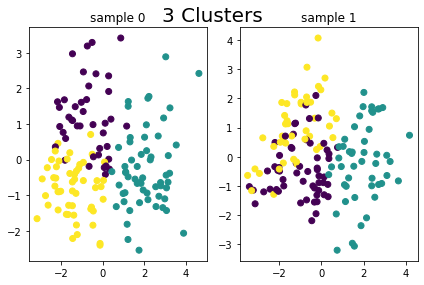

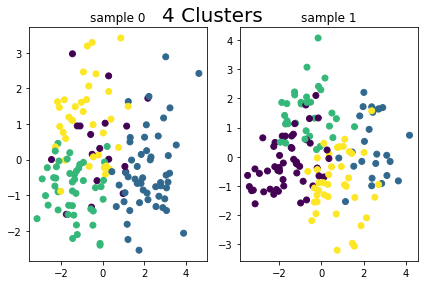

<IPython.core.display.Javascript object>

In [14]:
for cluster in range(2, 5):
    # making a subplot grid
    f, axarr = plt.subplots(1, 2)

    # making a plot for each sample
    for i in range(2):
        # PCA-created features.
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

The 2 cluster outcome is the only consistent one.

### Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

In [16]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(scaled)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(scaled)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(scaled)

print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_2)))
print(
    "ARI for three cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_3))
)
print("ARI for four cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.280694132678885
ARI for four cluster k-means: 0.19162596502170298


<IPython.core.display.Javascript object>

The 2 cluster solution produced the highest ARI score.

### Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [17]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(scaled)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(scaled)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(scaled)

print(
    "Silhouette score for two cluster k-means: {}".format(
        metrics.silhouette_score(scaled, pred_2, metric="euclidean")
    )
)
print(
    "Silhouette score for three cluster k-means: {}".format(
        metrics.silhouette_score(scaled, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster k-means: {}".format(
        metrics.silhouette_score(scaled, pred_4, metric="euclidean")
    )
)

Silhouette score for two cluster k-means: 0.17440650461256255
Silhouette score for three cluster k-means: 0.1286219070218783
Silhouette score for four cluster k-means: 0.1314736248593191


<IPython.core.display.Javascript object>

Here, the 2 cluster solution produces the highest silhouette score.